In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import matplotlib as mpl
import numpy as np
import scipy as sp
import json
import sys

In [2]:
df = pd.read_csv('./project_pipeline/data/classified_files_3.tsv', sep='\t').astype('object')
df.head()

,uniprot,pdb,region_1,region_2,complex_rmsd,percent_region_1,percent_region_2,2_aligned,2_comp,conformation,state,organism,date,notes
0,A0A0R4I961,6gtv,155-279,3-147,1.45,100.0,100.0,1.673,1.135,Open,Active,Escherichia coli F18+,['2018-06-19'],NaN
1,A0A0R4I961,6gtz,155-279,3-147,1.631,100.0,100.0,1.648,3.014,Open,Active,Escherichia coli F18+,['2018-06-19'],NaN
2,A0A0R4I961,6gu0,155-279,3-147,2.105,100.0,100.0,1.788,4.298,Open,Active,Escherichia coli F18+,['2018-06-19'],NaN
3,B5XAZ0,7bfk,116-120,1-115,4.781,100.0,83.478261,2.6,0.965,Closed,Autoinhibited,Salmo salar,['2021-01-04'],NaN
4,B5XAZ0,7bfl,116-120,1-115,2.591,100.0,79.130435,2.76,0.807,Closed,Autoinhibited,Salmo salar,['2021-01-04'],NaN


In [3]:
plt.style.use('ggplot')

c:\Users\User\miniconda3\envs\test_snek\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\miniconda3\envs\test_snek\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\miniconda3\envs\test_snek\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\miniconda3\envs\test_snek\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

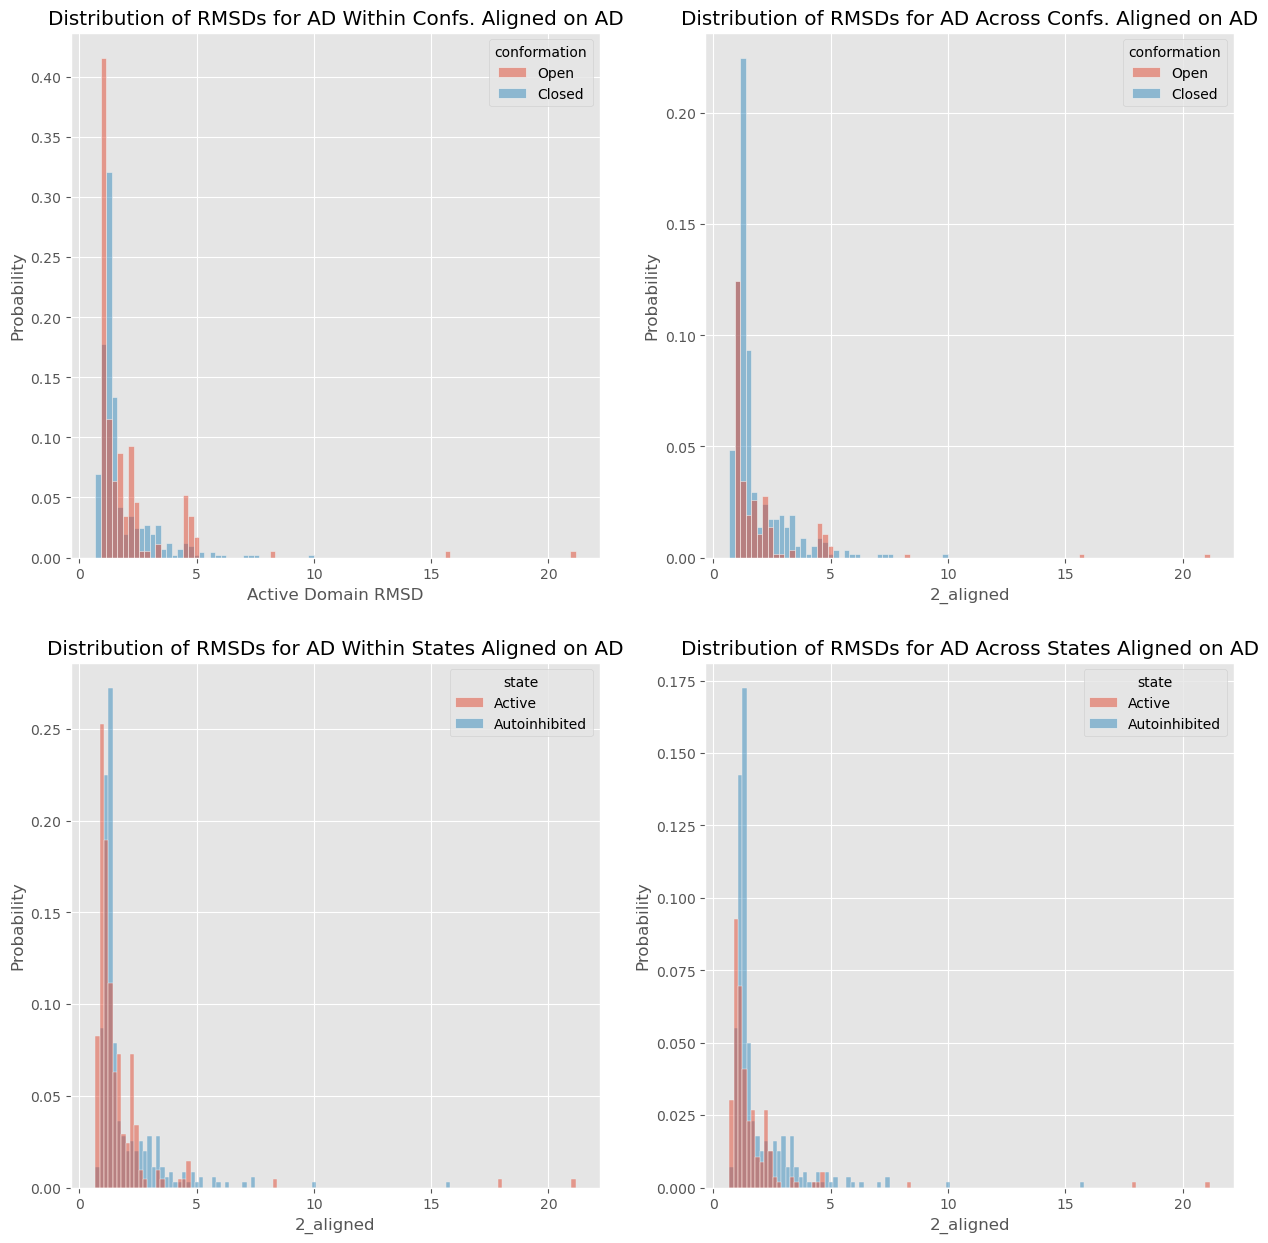

In [10]:
'''
Histograms of RMSDs for region 2 when aligned on region 2. 
'''

df_open = df[df['conformation'] == 'Open']
df_closed = df[df['conformation'] == 'Closed']

'''
Within each conformation, plot the distribution of the 2_aligned values. This shows us the distribution of RMSDS as probabilities within each conformation (i.e. how many
of the RMSDs for open conformations are between 0 and 1, how many are between 1 and 2, etc.)
'''
f, ax = plt.subplots(figsize=(15, 15), nrows=2, ncols=2)
sns.histplot(data=df, x='2_aligned', hue='conformation', stat='probability', common_norm=False, ax=ax[0][0])
ax[0][0].set_title('Distribution of RMSDs for AD Within Confs. Aligned on AD')
ax[0][0].set_xlabel('Active Domain RMSD')

'''
Across both conformations, plot the distribution of the 2_aligned values. This shows us the distribution of RMSDs as probabilities across both conformations,
which also shows their relative abundance to each other. 
'''
sns.histplot(data=df, x='2_aligned', hue='conformation', stat='probability', ax=ax[0][1])
ax[0][1].set_title('Distribution of RMSDs for AD Across Confs. Aligned on AD')

'''
Within each state, plot the distribution of the 2_aligned values. See the first graph for conceptual explanation.
'''
sns.histplot(data=df, x='2_aligned', hue='state', stat='probability', common_norm=False, ax=ax[1][0])
ax[1][0].set_title('Distribution of RMSDs for AD Within States Aligned on AD')

'''
Across both states, plot the distribution of the 2_aligned values. See the second graph for conceptual explanation.
'''
sns.histplot(data=df, x='2_aligned', hue='state', stat='probability', ax=ax[1][1])
ax[1][1].set_title('Distribution of RMSDs for AD Across States Aligned on AD')

plt.savefig('./project_pipeline/data/figures/2_aligned.png')
plt.show()

c:\Users\User\miniconda3\envs\test_snek\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\miniconda3\envs\test_snek\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\miniconda3\envs\test_snek\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\miniconda3\envs\test_snek\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

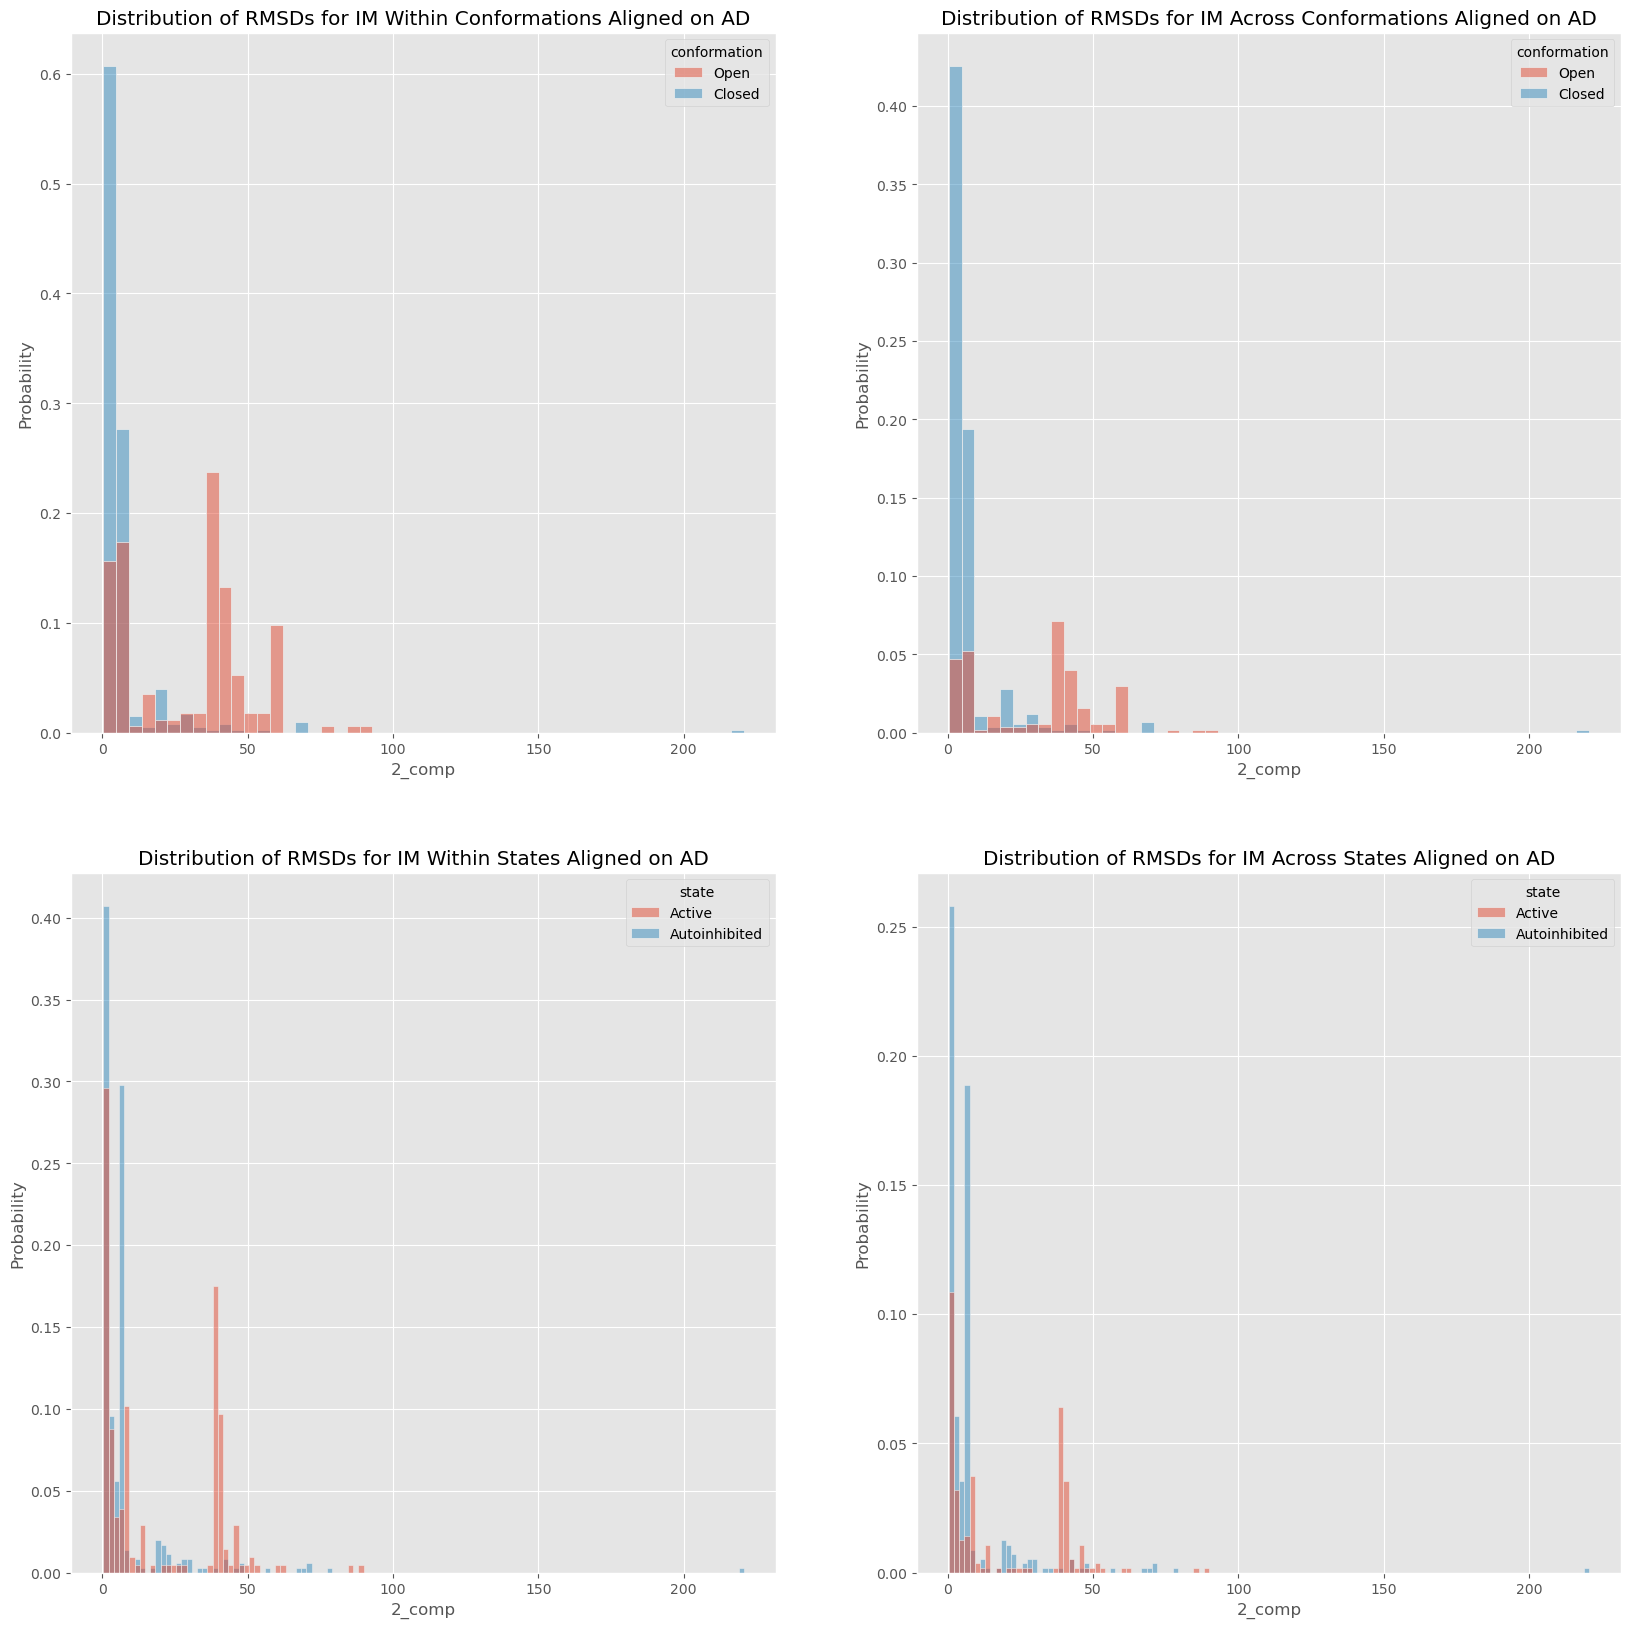

In [11]:
'''
Histograms of RMSDs for region 1 when aligned on region 2
'''

'''
Within each conformation, plot the distribution of the 2_comp values
'''
f, ax = plt.subplots(figsize=(20, 20), nrows=2, ncols=2)
sns.histplot(data=df, x='2_comp', hue='conformation', stat='probability', common_norm=False, ax=ax[0][0])
ax[0][0].set_title('Distribution of RMSDs for IM Within Conformations Aligned on AD')

'''
Across both conformations, plot the distribution of the 2_aligned values
'''
sns.histplot(data=df, x='2_comp', hue='conformation', stat='probability', ax=ax[0][1])
ax[0][1].set_title('Distribution of RMSDs for IM Across Conformations Aligned on AD')

'''
Within each state, plot the distribution of the 2_aligned values
'''
sns.histplot(data=df, x='2_comp', hue='state', stat='probability', common_norm=False, ax=ax[1][0])
ax[1][0].set_title('Distribution of RMSDs for IM Within States Aligned on AD')

'''
Across both states, plot the distribution of the 2_aligned values
'''
sns.histplot(data=df, x='2_comp', hue='state', stat='probability', ax=ax[1][1])
ax[1][1].set_title('Distribution of RMSDs for IM Across States Aligned on AD')


plt.savefig('./project_pipeline/data/figures/2_comp.png')
plt.show()

c:\Users\User\miniconda3\envs\test_snek\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\miniconda3\envs\test_snek\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\miniconda3\envs\test_snek\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\miniconda3\envs\test_snek\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

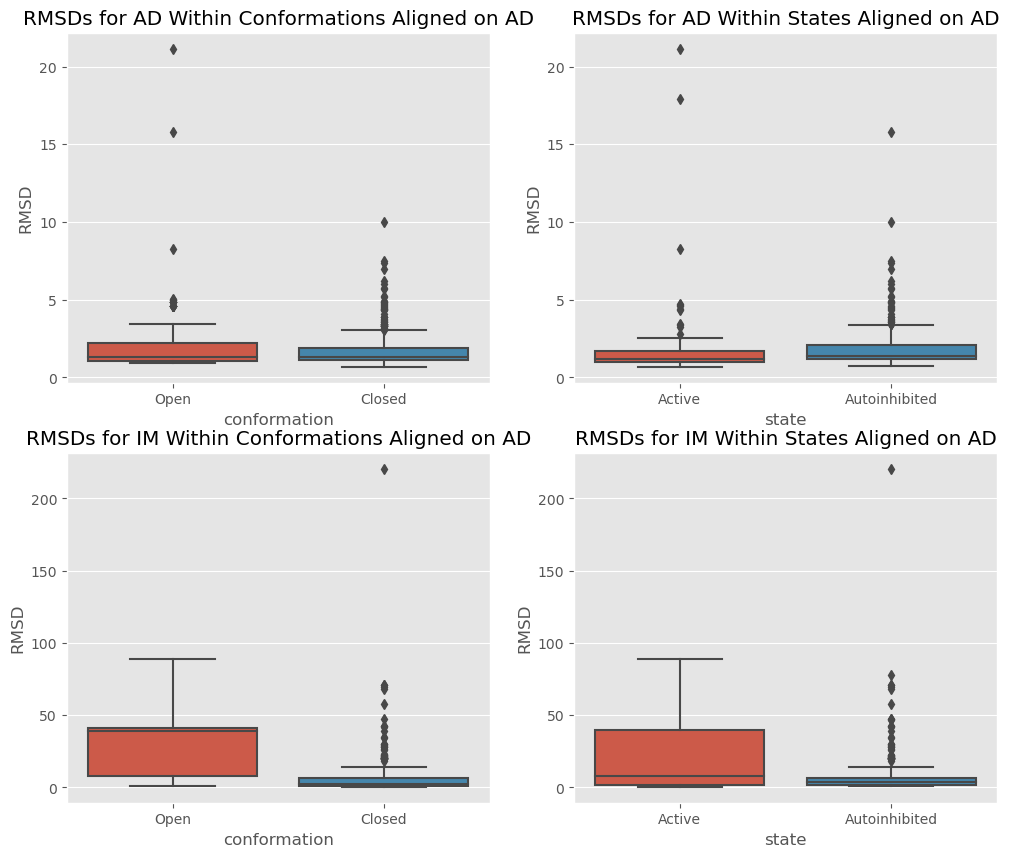

c:\Users\User\miniconda3\envs\test_snek\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\miniconda3\envs\test_snek\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


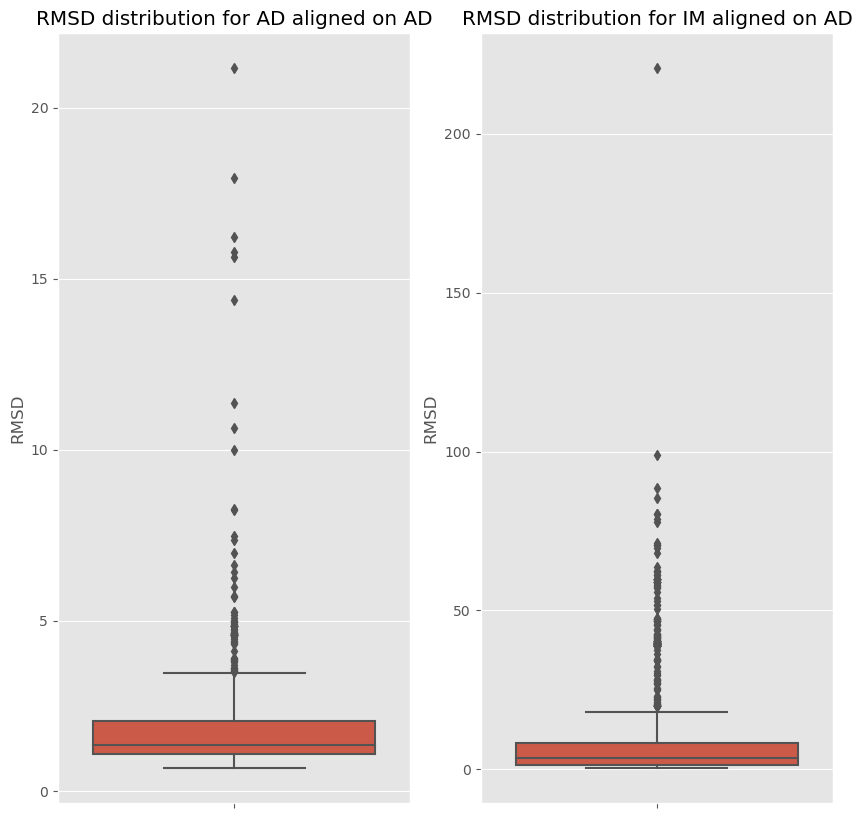

In [14]:
'''
Box plots of the RMSDs
'''

f, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))


sns.boxplot(data=df, x='conformation', y='2_aligned', ax=ax[0][0])
ax[0][0].set_title('RMSDs for AD Within Conformations Aligned on AD')
ax[0][0].set_ylabel('RMSD')

sns.boxplot(data=df, x='state', y='2_aligned', ax=ax[0][1])
ax[0][1].set_title('RMSDs for AD Within States Aligned on AD')
ax[0][1].set_ylabel('RMSD')

sns.boxplot(data=df, x='conformation', y='2_comp', ax=ax[1][0])
ax[1][0].set_title('RMSDs for IM Within Conformations Aligned on AD')
ax[1][0].set_ylabel('RMSD')

sns.boxplot(data=df, x='state', y='2_comp', ax=ax[1][1])
ax[1][1].set_title('RMSDs for IM Within States Aligned on AD')
ax[1][1].set_ylabel('RMSD')

plt.savefig('./project_pipeline/data/figures/distribution_per_region.png')
plt.show()

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
sns.boxplot(data=df, y='2_aligned', ax=ax[0])
ax[0].set_title('RMSD distribution for AD aligned on AD')
ax[0].set_ylabel('RMSD')

sns.boxplot(data=df, y='2_comp', ax=ax[1])
ax[1].set_title('RMSD distribution for IM aligned on AD')
ax[1].set_ylabel('RMSD')

plt.savefig('./project_pipeline/data/figures/no_subcategorization.png')

In [17]:
'''
Summary statistics
'''

df.agg({'2_aligned': ['min', 'max', 'median', 'mean', 'skew'],
        '2_comp': ['min', 'max', 'median', 'mean', 'skew']})

,2_aligned,2_comp
min,0.683000,0.404000
max,21.158000,220.629000
median,1.367000,3.572500
mean,1.923658,12.104697
skew,5.374823,3.058221


c:\Users\User\miniconda3\envs\test_snek\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


824


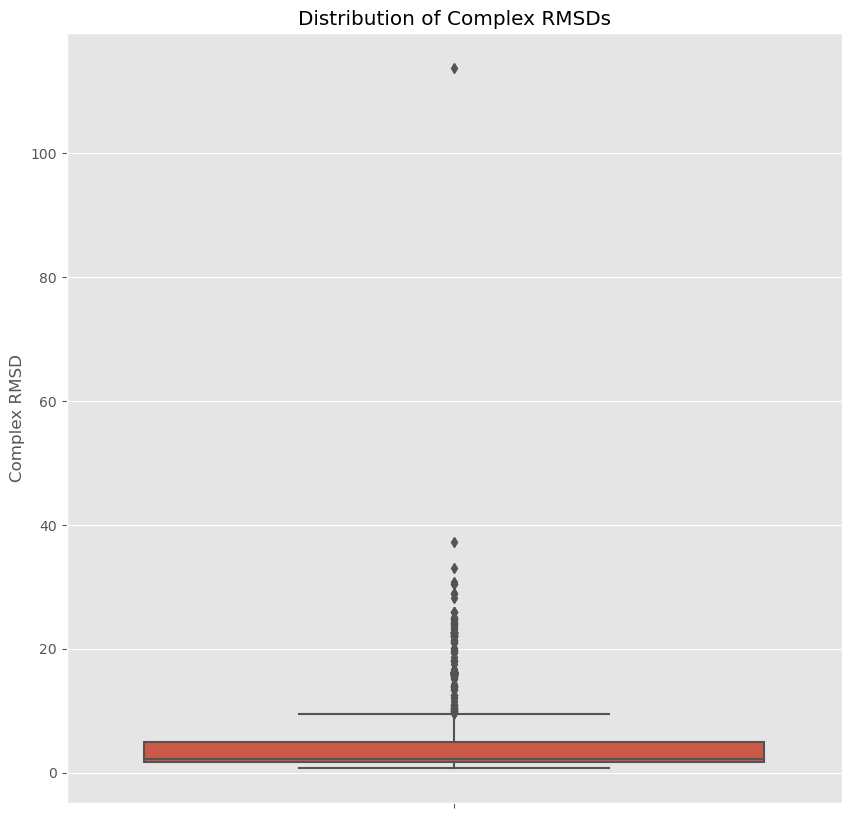

In [9]:
f, ax = plt.subplots(figsize=(10, 10))

sns.boxplot(data=df, y='complex_rmsd', ax=ax)
ax.set_ylabel('Complex RMSD')
ax.set_title('Distribution of Complex RMSDs')
plt.savefig('./project_pipeline/data/figures/complex_rmsd.png')
print(len(df))